In [1]:
import numpy as np
import pandas as pd
import pandas_dedupe
import matplotlib.pyplot as plt
import spacy
import json
import re
import tqdm

nlp = spacy.load("en_core_web_lg")

PATH_TO_FEED = "DEDUPED_Heat_Not_Burn_search_result_2019-07-24_07_48_28.067985.jsonl"

articles = []
for line in open(PATH_TO_FEED):
    articles.append(json.loads(line)["_source"])
print('Loaded {} docs'.format(len(articles)))

Loaded 485 docs


# Document Level Analysis with Minimal Threshold

In [15]:
#DOCUMENT LEVEL

harm_reduction_keywords = ["harm", "reduce", "alternative", "safe", "healthy", "help", "quit", "switch"]
#ensure keywords are in fact properly lemmanized
for i in range(len(harm_reduction_keywords)):
    harm_reduction_keywords[i] = nlp(harm_reduction_keywords[i])[0].lemma_.lower()
    
    
count_by_date = {} #{"MM/YYYY":[PMI related docs, JUUL related docs, IQOS related docs, Total docs written] } 
                    #counts the references to harm reduction with resepect to PMI, IQOS, JUUL
PMI = 0
JUUL = 1
IQOS = 2
TOTAL_DOCS = 3

#populate 
for year in range(1990,2020):
    for month in range(1,13):
        for day in range(1,32):
            
            if((month == 4 or month == 6 or month == 9 or month == 11) and day == 31 or (month == 2 and day > 28)):
                break
            
            date = str(year)+"-"
            if month < 10:
                date += "0"
            date += str(month)+"-"
            if day < 10:
                date += "0"
            date += str(day)
            count_by_date[date] = [0,0,0,0]
            
            
def format_date(string):
    return string[:10]


aliases_list = [
    ["pmi", "philip morris", "calantzopoulos"],
    ["juul", "burns"],
    ["iqos"]
]

def check_aliases(COMPANY, ents):
    for ent in ents:
        if ent.text.lower() in aliases_list[COMPANY]:
            return True
    return False

THRESHOLD = .75
#iterate through the documents
for article in tqdm.tqdm_notebook(articles):
    date = format_date(article["date"])
    count_by_date[date][TOTAL_DOCS] += 1
    
    #1. check for pro-industry
    if article["first_ten_sent_prob_avg"] > THRESHOLD:
        doc = nlp(article["text"])
        
        #2. check for harm reduction keyword
        for i, word in enumerate(doc):
            if word.lemma_.lower() in harm_reduction_keywords:
                
                #3. check for PMI, JUUL, IQOS
                if check_aliases(PMI,doc.ents):
                    count_by_date[date][PMI] +=1
                if check_aliases(JUUL,doc.ents):
                    count_by_date[date][JUUL] +=1
                if check_aliases(IQOS,doc.ents):                
                    count_by_date[date][IQOS] +=1
                
                break
                    

HBox(children=(IntProgress(value=0, max=485), HTML(value='')))

In [16]:
data = np.asarray(list(count_by_date.items()))

PMI_harm_reduction = [item[PMI] for item in data[:,1]]
JUUL_harm_reduction = [item[JUUL] for item in data[:,1]]
IQOS_harm_reduction = [item[IQOS] for item in data[:,1]]
dates = list(count_by_date.keys())
years = [year[:4] for year in list(count_by_date.keys())[::12]]

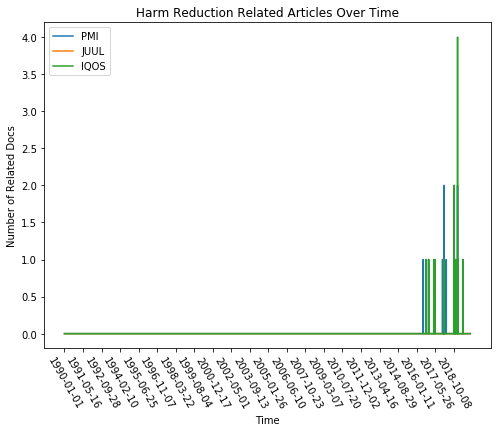

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(PMI_harm_reduction)), PMI_harm_reduction,label="PMI")
plt.plot(range(len(PMI_harm_reduction)), JUUL_harm_reduction,label="JUUL")
plt.plot(range(len(PMI_harm_reduction)), IQOS_harm_reduction,label="IQOS")
plt.title("Harm Reduction Related Articles Over Time")
plt.xlabel("Time")
plt.xticks(range(len(data))[::500], data[::500,0], rotation=300)
plt.ylabel("Number of Related Docs")
plt.legend()
plt.show()


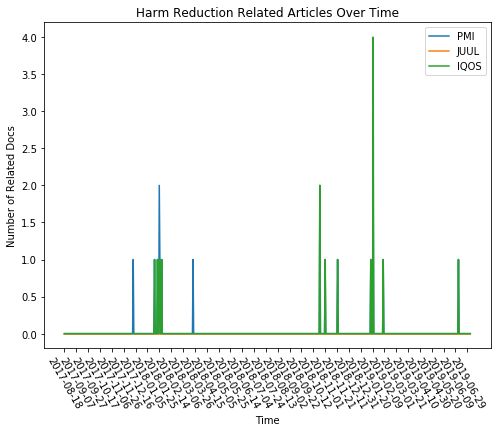

In [18]:
plt.figure(figsize=(8, 6))
start = 12*26*32 + 100
end = 12*26*35-150
plt.plot(range(len(PMI_harm_reduction))[start:end], PMI_harm_reduction[start:end],label="PMI")
plt.plot(range(len(PMI_harm_reduction))[start:end], JUUL_harm_reduction[start:end],label="JUUL")
plt.plot(range(len(PMI_harm_reduction))[start:end], IQOS_harm_reduction[start:end],label="IQOS")
plt.title("Harm Reduction Related Articles Over Time")
plt.xlabel("Time")
plt.xticks(range(len(dates))[start:end:20],dates[start:end:20], rotation=300)
plt.ylabel("Number of Related Docs")
plt.legend()
plt.show()

In [14]:
peak_dates = [date for date, val in count_by_date.items() if val[IQOS] > 1]

for peak_date in peak_dates:
    for article in tqdm.tqdm_notebook(articles): 
        if article["first_ten_sent_prob_avg"] > THRESHOLD and peak_date == format_date(article["date"]) and check_aliases(IQOS,nlp(article["text"]).ents):
            print(peak_date, article["title"],"\n")
            
            
            
            

HBox(children=(IntProgress(value=0, max=485), HTML(value='')))

2018-10-23 Philip Morris seeks bigger Japan share with cheaper heat-not-burn tobacco 

2018-10-23 Heated tobacco product claims by tobacco industry scrutinized by UCSF researchers 




HBox(children=(IntProgress(value=0, max=485), HTML(value='')))

2019-01-21 IQOS point-of-sale marketing strategies in Israel: a pilot study 

2019-01-21 welcome IQOS AND HEETS LEBANON 

2019-01-21 IQOS – This Changes Everything 

2019-01-21 Ubervape IQOS 




In [ ]:
# TODO